# Books Recommender for Children using GoodReads data
August 9th 2025 

This notebook provides a clean, analysis-ready dataset for further modeling or recommendation tasks.

---

## Inputs

- **Raw Data:** Multiple JSON files in `data/all/`, each line is an individual JSON record.
- **DataFrames:**
  - `books_df`: Book metadata (ISBN, book_id, title, average_rating, description, etc.)
  - `reviews_df`: User reviews (user_id, book_id, review_id, rating, review_text, n_votes)

---

## Processing Steps

1. **Data Loading:** All JSON files are read into pandas DataFrames.
2. **Book Data Preparation:** Selected columns from the books DataFrame are cleaned and formatted, including handling missing publication years.
3. **Review Aggregation:**
   - Count total reviews per book.
   - Filter reviews to only those with `n_votes > 0`.
   - For each book, select the top 20 reviews by number of votes.
   - Aggregate these reviews: concatenate review texts and sum votes.
   - Merge review aggregates with review counts.
4. **Final Dataset Creation:** Merge the processed reviews with selected book metadata.
5. **Exploratory Analysis:** 
   - Check for missing values.
   - Display summary statistics for numeric columns.
   - Visualize distributions of key numeric features.
6. **Output:** Save the final merged DataFrame as a CSV file in `data/clean/books_with_reviews.csv`.

---

## Outputs

- **books_with_reviews.csv:** A cleaned, aggregated dataset containing book metadata, review counts, concatenated top reviews, and total votes for those reviews.

---

This notebook prepares the data for further modeling or recommendation tasks.

In [39]:
import pandas as pd
import numpy as np
import glob
import os

In [72]:
pd.set_option('display.max_colwidth', None)

In [56]:


# Set the directory containing JSON files
json_dir = os.path.join(os.getcwd(), '..', 'data/all/')

# Find all JSON files in the directory
json_files = glob.glob(os.path.join(json_dir, '*.json'))
print(f"Found {len(json_files)} JSON files in {json_dir}")
print("Files:", json_files)
# Read each JSON into a dictionary of DataFrames
dataframes = {}
for file in json_files:
    name = os.path.splitext(os.path.basename(file))[0]
    dataframes[name] = pd.read_json(file, lines=True)

# Display the names and shapes of loaded DataFrames
for name, df in dataframes.items():
    print(f"{name}: {df.shape}")

Found 2 JSON files in /Users/karanmatnani/Documents/code/kids_book_recommender/src/../data/all/
Files: ['/Users/karanmatnani/Documents/code/kids_book_recommender/src/../data/all/goodreads_books_children.json', '/Users/karanmatnani/Documents/code/kids_book_recommender/src/../data/all/goodreads_reviews_children.json']
goodreads_books_children: (124082, 29)
goodreads_reviews_children: (734640, 11)


In [57]:
dataframes

{'goodreads_books_children':               isbn  text_reviews_count    series country_code language_code  \
 0       1599150603                   7        []           US                 
 1       1934876569                   6  [151854]           US                 
 2       0590417010                 193        []           US           eng   
 3       0915190575                   4        []           US                 
 4       1416904999                   4        []           US                 
 ...            ...                 ...       ...          ...           ...   
 124077                               1        []           US                 
 124078                               7        []           US         en-GB   
 124079  0061960314                  13        []           US                 
 124080  0689852959                   1        []           US                 
 124081  0765197456                   6        []           US                 
 
          

In [59]:
dataframes['goodreads_books_children'].columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

In [60]:
books_df = dataframes['goodreads_books_children'][['isbn', 'book_id', 'title', 'average_rating', 'similar_books', 'description', 'format', 'link', 'authors','publisher', 'num_pages','publication_year']]
books_df

,isbn,book_id,title,average_rating,similar_books,description,format,link,authors,publisher,num_pages,publication_year
0,1599150603,287141,The Aeneid for Boys and Girls,4.13,[],"Relates in vigorous prose the tale of Aeneas, ...",Paperback,https://www.goodreads.com/book/show/287141.The...,"[{'author_id': '3041852', 'role': ''}]",Yesterday's Classics,162,2006
1,1934876569,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,4.22,"[948696, 439885, 274955, 12978730, 372986, 216...","To Kara's astonishment, she discovers that a p...",Paperback,https://www.goodreads.com/book/show/6066812-al...,"[{'author_id': '19158', 'role': ''}]",Seven Seas,216,2009
2,0590417010,89378,Dog Heaven,4.43,"[834493, 452189, 140185, 1897316, 2189812, 424...",In Newbery Medalist Cynthia Rylant's classic b...,Hardcover,https://www.goodreads.com/book/show/89378.Dog_...,"[{'author_id': '5411', 'role': ''}]",Blue Sky Press,40,1995
3,0915190575,3209312,"Moths and Mothers, Feathers and Fathers: A Sto...",4.29,[],,,https://www.goodreads.com/book/show/3209312-mo...,"[{'author_id': '589328', 'role': ''}, {'author...",,,
4,1416904999,1698376,What Do You Do?,3.57,[],WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,Board Book,https://www.goodreads.com/book/show/1698376.Wh...,"[{'author_id': '169159', 'role': ''}]",Little Simon,24,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
124077,,24558598,Children's Books: Oliver and the Dragon,4.00,[],,,https://www.goodreads.com/book/show/24558598-c...,"[{'author_id': '421368', 'role': ''}]",,,
124078,,13057172,Gangsta Granny,4.27,"[1255132, 12899180, 16106863, 12102926, 105904...",Another hilarious and moving novel from David ...,,https://www.goodreads.com/book/show/13057172-g...,"[{'author_id': '313653', 'role': ''}]",HarperCollinsChildren'sBooks,205,2011
124079,0061960314,7925060,Instructions,4.29,"[7552359, 7493149, 9762805, 8409657, 3049514, ...","""A perfect reminder to always be on the lookou...",Hardcover,https://www.goodreads.com/book/show/7925060-in...,"[{'author_id': '1221698', 'role': ''}, {'autho...",HarperCollins,40,2010
124080,0689852959,331839,Jacqueline Kennedy Onassis: Friend of the Arts,4.36,[],One of the most popular series ever published ...,Paperback,https://www.goodreads.com/book/show/331839.Jac...,"[{'author_id': '10681', 'role': ''}, {'author_...",Aladdin,176,2002


In [61]:
reviews_df = dataframes['goodreads_reviews_children'][['user_id', 'book_id', 'review_id', 'rating', 'review_text','n_votes']]
reviews_df

,user_id,book_id,review_id,rating,review_text,n_votes
0,8842281e1d1347389f2ab93d60773d4d,23310161,f4b4b050f4be00e9283c92a814af2670,4,Fun sequel to the original.,7
1,8842281e1d1347389f2ab93d60773d4d,17290220,22d424a2b0057b18fb6ecf017af7be92,5,One of my favorite books to read to my 5 year ...,4
2,8842281e1d1347389f2ab93d60773d4d,6954929,50ed4431c451d5677d98dd25ca8ec106,5,One of the best and most imaginative childrens...,6
3,8842281e1d1347389f2ab93d60773d4d,460548,1e4de11dd4fa4b7ffa59b6c69a6b28e9,5,My daughter is loving this. Published in the 6...,5
4,8842281e1d1347389f2ab93d60773d4d,11474551,2065145714bf747083a1c9ce81d5c4fe,5,A friend sent me this. Hilarious!,5
...,...,...,...,...,...,...
734635,480ac8b4df39533a6c7fe6ae109aa56a,65112,6251b6332ee9f898fe0e975821eb747e,2,Does not give a satisfying ending to the serie...,0
734636,afcd096765a8c354be0706ab1324999b,555999,a4f8b16d5c0c5dc08d0f3fa118a262b4,5,My mother gave me this book as a gift... it's ...,0
734637,d94c83867337514c94738b57a1d19677,389627,a5964e464961cf0185d31e00a7a9ffac,2,"If I were a middle grade kid, I'd prolly give ...",0
734638,48a10d546ba07520ce194dc18e687be4,378,42729a1e85ca16fa5e4a44ffccd020e4,5,I have a limited selection of childhood books ...,0


In [ ]:
books_df['publication_year'] = books_df['publication_year'].replace('', np.nan).fillna(-1).astype(int)

/var/folders/pp/st7r4cq55bddv8kl4v7w297r0000gn/T/ipykernel_81013/210041433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['publication_year'] = books_df['publication_year'].replace('', np.nan).fillna(-1).astype(int)


In [ ]:
books_df[((books_df['publication_year'] > 2010) & (books_df['average_rating']>4.5))].sort_values(by='publication_year', ascending=False).head(10)

,isbn,book_id,title,average_rating,similar_books,description,format,link,authors,publisher,num_pages,publication_year
7369,1442430567,18668504,Jack Frost: The End Becomes the Beginning (The...,4.56,[],The Guardians' powers are given the ultimate t...,Hardcover,https://www.goodreads.com/book/show/18668504-j...,"[{'author_id': '137553', 'role': ''}]",Atheneum/Caitlyn Dlouhy Books,240,2018
5851,1626726035,34506921,Dude!,4.60,[],,Hardcover,https://www.goodreads.com/book/show/34506921-dude,"[{'author_id': '248589', 'role': ''}, {'author...",Roaring Brook Press,,2018
4103,1681195518,35697920,Lola Dutch,4.56,[],"Meet Lola Dutch, a creative girl who is bursti...",Hardcover,https://www.goodreads.com/book/show/35697920-l...,"[{'author_id': '861586', 'role': ''}, {'author...",Bloomsbury USA Childrens,40,2018
18,,34680604,Sir Chocolate and the sugar dough bees story a...,4.55,[],A greedy snail damages the flower fields and t...,Paperback,https://www.goodreads.com/book/show/34680604-s...,"[{'author_id': '15584446', 'role': ''}, {'auth...",TSL Publications,,2017
4307,,36283767,Armstrong: Den första musen på månen,4.51,[],For lange sedan hade en liten mus en stor drom...,Hardcover,https://www.goodreads.com/book/show/36283767-a...,"[{'author_id': '7377207', 'role': ''}]",Lilla Piratforlaget,122,2017
2020,098761570X,35054843,Pepsi the Problem Puppy,4.83,[],From the moment Pepsi launches into her new ho...,Paperback,https://www.goodreads.com/book/show/35054843-p...,"[{'author_id': '16520058', 'role': ''}, {'auth...",Faraway Nearby Ink,116,2017
3030,1634890876,36026656,How to Turn Your Mom Into a Monster,4.55,[],Do you like smearing your lunch all over yours...,Paperback,https://www.goodreads.com/book/show/36026656-h...,"[{'author_id': '7188768', 'role': ''}]",Wise Ink,,2017
3169,0803737009,31626023,Blue Sky White Stars,4.51,[],An inspiring and patriotic tribute to the beau...,Hardcover,https://www.goodreads.com/book/show/31626023-b...,"[{'author_id': '6910732', 'role': 'Illustratio...",Dial Books,40,2017
3858,1988046025,35084051,Magelica's Voyage to the Land of the Fairies (...,4.69,[],Magelica's Voyage to the Land of the Fairiesis...,Paperback,https://www.goodreads.com/book/show/35084051-m...,"[{'author_id': '7544508', 'role': ''}]",Magelica Inc.,68,2017
5544,0763689238,30764358,Botanicum: Welcome to the Museum,4.54,[],"Botanicum, is a curated guide to plant life. F...",Hardcover,https://www.goodreads.com/book/show/30764358-b...,"[{'author_id': '2161759', 'role': 'Contributor...",Big Picture Press,112,2017


In [ ]:
books_df[((books_df['average_rating'] > 4.9) & (books_df['publication_year'] > 2010))].sort_values(by='publication_year', ascending=False).head(10)

,isbn,book_id,title,average_rating,similar_books,description,format,link,authors,publisher,num_pages,publication_year
508,,36318802,Myrtle the Purple Turtle,5.00,[],Myrtle is a lovely Turtle. Not an ordinary Tur...,Kindle Edition,https://www.goodreads.com/book/show/36318802-m...,"[{'author_id': '7072186', 'role': ''}, {'autho...",Weaverback Press,30,2017
1954,,35559368,Why Did You Choose Me?,5.00,[],Most adoptive and foster children struggle at ...,Hardcover,https://www.goodreads.com/book/show/35559368-w...,"[{'author_id': '16993545', 'role': ''}]",Ambassador International,,2017
1357,0997801700,32851988,Raffi and Friends - The Lunch Box Mystery,5.00,[],"Raffi is a playful, little giraffe who loves g...",Paperback,https://www.goodreads.com/book/show/32851988-r...,"[{'author_id': '8331861', 'role': ''}]",V I Productions,32,2016
2048,1944277323,31188836,Legend of the Forest Beast,5.00,[],The beloved tutor Alchir has vanished! And a d...,Paperback,https://www.goodreads.com/book/show/31188836-l...,"[{'author_id': '4774874', 'role': ''}]",Progressive Rising Phoenix Press,178,2016
8070,9781941859,25281693,Journey to Honeysuckle Mountain (The Adventure...,4.93,"[17887947, 15831747, 13829032, 16119075, 67109...",After returning home with his friends from the...,Paperback,https://www.goodreads.com/book/show/25281693-j...,"[{'author_id': '7356830', 'role': ''}]",Pegasus Pony,27,2015
3644,1409582086,25818776,Look Inside Trains,5.00,[],From traditional steam trains to super-fast bu...,Paperback,https://www.goodreads.com/book/show/25818776-l...,"[{'author_id': '746565', 'role': ''}]",Usborne Books,14,2015
3646,1511552557,25640704,Hope --The Story of a Banana-Fish,5.00,[],Let yourself become immersed into an aquatic f...,Paperback,https://www.goodreads.com/book/show/25640704-h...,"[{'author_id': '14548314', 'role': ''}]",CreateSpace Independent Publishing Platform,118,2015
6414,1023504766,29349362,Pop-up hi han,5.00,[],Presentation de l'editeur\nQuel remue-menage c...,Board book,https://www.goodreads.com/book/show/29349362-p...,"[{'author_id': '904223', 'role': ''}]",Seuil Jeunesse,,2015
5642,,22614254,Odd Sock's BIG Scottish Adventure (Odd Sock Ad...,4.96,[],Alternate Cover Edition for ASIN B00LD3Q3JU\n>...,Kindle Edition,https://www.goodreads.com/book/show/22614254-o...,"[{'author_id': '7467034', 'role': ''}]","Amazon Digital Services, Inc.",86,2014
8164,,26850231,Banyan and the Green Bee King Save the Bees,5.00,[],"In a plight to save the disappearing bees, the...",Paperback,https://www.goodreads.com/book/show/26850231-b...,"[{'author_id': '8079945', 'role': ''}]",CreateSpace Independent Publishing Platform,24,2014


In [62]:
books_df[books_df['title'].str.contains('The Enchanted Wood', case=False, na=False)].sort_values(by='publication_year', ascending=False)  

,isbn,book_id,title,average_rating,similar_books,description,format,link,authors,publisher,num_pages,publication_year
87723,1405272198,23149848,"The Enchanted Wood (The Faraway Tree, #1)",4.24,"[440403, 1099466, 862890, 1455149, 977817, 138...","Joe, Beth and Franny move to the country and f...",Paperback,https://www.goodreads.com/book/show/23149848-t...,"[{'author_id': '10657', 'role': ''}]",Egmont,210,2014
75853,0603566243,17786689,The Enchanted Wood,4.24,"[440403, 1099466, 862890, 1455149, 977817, 138...","Joe, Beth and Franny move to the country and f...",Hardcover,https://www.goodreads.com/book/show/17786689-t...,"[{'author_id': '10657', 'role': ''}, {'author_...",Dean,156,2011
123875,0603561977,935159,The Enchanted Wood,4.24,"[440403, 1099466, 862890, 1455149, 977817, 138...","Joe, Beth and Franny move to the country and f...",Hardcover,https://www.goodreads.com/book/show/935159.The...,"[{'author_id': '10657', 'role': ''}]",Dean,,2010
83538,1405230274,319966,The Enchanted Wood,4.24,"[440403, 1099466, 862890, 1455149, 977817, 138...","Joe, Beth and Franny move to the country and f...",Paperback,https://www.goodreads.com/book/show/319966.The...,"[{'author_id': '10657', 'role': ''}, {'author_...",Egmont,248,2007
107189,,12535672,The Enchanted Wood (Faraway Tree #1),4.24,"[440403, 1099466, 862890, 1455149, 977817, 138...",Alternate cover version ISBN 1865159697\nWhen ...,Hardcover,https://www.goodreads.com/book/show/12535672-t...,"[{'author_id': '10657', 'role': ''}]",Hinkler Books,186,2004
56183,0967290201,458381,The Enchanted Wood,4.18,"[11735733, 17055449, 17780848, 20759748, 14930...",Three princes go on a quest to the Heart of th...,Hardcover,https://www.goodreads.com/book/show/458381.The...,"[{'author_id': '68042', 'role': ''}]",Golden Wood Studio,32,1999
74529,0603550916,1513771,"Enid Blyton Collection: The Enchanted Wood, Th...",4.28,"[862890, 125190, 1455149, 578270, 1153709, 345...","The Enchanted Wood, The Magic Faraway Tree, Th...",Hardcover,https://www.goodreads.com/book/show/1513771.En...,"[{'author_id': '10657', 'role': ''}]",Hamlyn,512,1992
64377,0091753147,935170,"The Enchanted Wood, The Magic Faraway Tree, Th...",4.54,"[2137777, 1474196, 1548563, 321135, 1133082, 1...",Omnibus edition with 5 titles in one book.,Hardcover,https://www.goodreads.com/book/show/935170.The...,"[{'author_id': '10657', 'role': ''}]",Red Fox,,1990
26863,0600555887,1369391,An Enid Blyton Collection : The Enchanted Wood...,4.28,"[862890, 125190, 1455149, 578270, 1153709, 345...","When Jo, Bessie and Fanny find a wonderful mag...",Hardcover,https://www.goodreads.com/book/show/1369391.An...,"[{'author_id': '10657', 'role': ''}]",Viscount,710,1987
109322,0868012327,1369376,"The Enchanted Wood (The Faraway Tree, #1)",4.24,"[440403, 1099466, 862890, 1455149, 977817, 138...","Joe, Beth and Franny move to the country and f...",Hardcover,https://www.goodreads.com/book/show/1369376.Th...,"[{'author_id': '10657', 'role': ''}]",Egmont,118,1984


In [ ]:
books_df[books_df['isbn'] == '0689304099'].values  

array([['0689304099', 'The Enchanted Forest', 3.7, list([]), '', '',
        'https://www.goodreads.com/book/show/2426418.The_Enchanted_Forest',
        list([{'author_id': '232179', 'role': ''}]), '', '', nan]],
      dtype=object)

In [ ]:
reviews_df[reviews_df['book_id'] == '2426418'].values    

array([], shape=(0, 6), dtype=object)

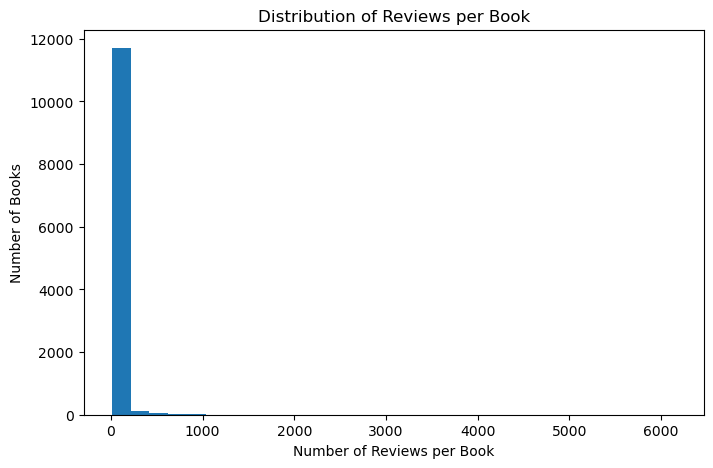

,book_id,num_reviews,title
88,3636,6156,"The Giver (The Giver, #1)"
0,5,4696,Harry Potter and the Prisoner of Azkaban (Harr...
74564,11387515,4499,Wonder (Wonder #1)
4678,157993,3114,The Little Prince
2403,78411,1999,The Bad Beginning (A Series of Unfortunate Eve...
70142,9673436,1947,The Invention of Hugo Cabret
323,8127,1721,"Anne of Green Gables (Anne of Green Gables, #1)"
9794,370493,1697,The Giving Tree
75083,11594337,1575,The One and Only Ivan
54,2998,1524,The Secret Garden


In [63]:
# Aggregate reviews: count number of reviews per book
review_counts = reviews_df.groupby('book_id').size().reset_index(name='num_reviews')

# Merge with books_df to get book titles
popular_books = pd.merge(review_counts, books_df[['book_id', 'title']], on='book_id')

# Sort by number of reviews, descending
popular_books_sorted = popular_books.sort_values(by='num_reviews', ascending=False)

# Show distribution of review counts
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(review_counts['num_reviews'][review_counts['num_reviews']>10], bins=30)
plt.xlabel('Number of Reviews per Book')
plt.ylabel('Number of Books')
plt.title('Distribution of Reviews per Book')
plt.show()

# Display top 10 most reviewed books
popular_books_sorted.head(10)

In [ ]:
review_counts

,book_id,num_reviews
0,5,462
1,50,89
2,61,4
3,93,34
4,236,2
...,...,...
40147,36340336,1
40148,36365127,1
40149,36391470,1
40150,36451351,1


In [64]:
books_df[books_df['book_id']==5].values

array([['043965548X', 5,
        'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
        4.53,
        list(['13759', '65111', '239917', '153800', '393145', '40159', '13927', '537070', '114956', '144007', '225092', '768878', '121823', '590324', '116560', '24785']),
        "Harry Potter's third year at Hogwarts is full of new dangers. A convicted murderer, Sirius Black, has broken out of Azkaban prison, and it seems he's after Harry. Now Hogwarts is being patrolled by the dementors, the Azkaban guards who are hunting Sirius. But Harry can't imagine that Sirius or, for that matter, the evil Lord Voldemort could be more frightening than the dementors themselves, who have the terrible power to fill anyone they come across with aching loneliness and despair. Meanwhile, life continues as usual at Hogwarts. A top-of-the-line broom takes Harry's success at Quidditch, the sport of the Wizarding world, to new heights. A cute fourth-year student catches his eye. And he becomes clo

In [73]:
reviews_df[['rating','review_text', 'n_votes']][reviews_df['book_id'] == 5].sort_values(by='n_votes', ascending=False)

,rating,review_text,n_votes
205095,4,I'm beginning to wonder if there will ever be a Defence Against The Dark Arts teacher who is just a teacher.,382
169571,5,"Still five stars. Love this so much. Can't review. Couldn't even take notes. Watched the movie immediately after finishing. Need next book. Wish I lived in this world. Damn you, Rowling.",216
575789,5,"Buddy-read with two of my Great Escape gal pals- Stepheny and Ivonne. \n Be on the look out for Stepheny Potthead aka The Book Pusher aka Quick Draw Stepheny aka The Nutty Professor. Last seen running along side the Knight Bus with Harry Potter's invisible cloak. Also Suspected in the kidnapping of fellow Goodreader Jeff and best-selling author Stephen King. Blonde Hair...big green doll eyes, has a frightening maniacal cackle and a tendency to whine when she doesn't get her way. LOUDLY. Considered armed and dangerous- approach with caution...and Nerds- she likes Nerds. \n Now back to our regularly scheduled review.... \n I don't listen to a lot of audio-books (I prefer to read) but I was kind of falling behind in my reading commitments...and I had put Ms. Stepheny off again and again for this buddy-read soooooo many times- I couldn't do it again to her (she pouts..and she gets all mopey and it is JUST heartbreaking). I am so happy I listened to this one- Stephen Fry was just perfect. Perfect!..and HARRY POTTER AND THE PRISONER OF AZKABAN was just the thing to put me in the Christmas Spirit. \n It's Harry's least favorite time of year- school break spent with the Dursleys...and this visit isn't going well. First: News that Sirius Black has escaped from Azkaban- Second: An unfortunate accident involving mean Aunt Marge... \n Harry decides not to stick around- and catches the Knight Bus to Diagon Alley- where instead of getting in trouble for using magic away from Hogwarts, he gets invited to stay until school begins, by Cornelius Fudge-the Minister for Magic. \n The night before he is expected to leave- Harry is warned that Sirius may have escaped with murder in mind- and HE may be the target.... \n This is my favorite of the series so far!! I loved that it was still light and fun...but that the darkness is slooooooooowly creeping in. \n I loved that a lot of it took place during the Christmas Holidays... \n I really liked the addition of the Dementors...spoooooky... \n ...and I adored Buckbeak!! \n As for the whereabouts of Stepheny? I can almost guarantee...she is up to no good.",119
477285,5,"Hogwarts will always be there to welcome you home. \n *I was feeling guilty okay?Seeing this in my currently reading shelf while in reality it was in standby mode. * \n And there are Moony,Padfoot,Prongs and Wormtail (Sexy names) in Prisoner of Azkaban....So, the welcome home thing gets even better. \n --Since my reading slump won't let me read or sleep ,I might as well try to knock some sense into mudblood people who still haven't picked up the perfection that is Harry Potter. Hey don't look at me accusing loathsome eyes, I'm not a racist just Slytherin. I'm supposed to say mean things like that.<< Gotta keep the stereotype and all. \n So lets talk about HOW your unassuming life will change if you read this magical series; \n De-friending not so innocent bystanders announcing ""Harry Potter is dumb"" or ""Harry Potter is for kids"" will become a common occurrence. Ask any potterhead, it happens a lot of times. \n What is your Hogwarts house will become your idea of small talk. \n You'll start saying Harry Potter cliches like""I'm still waiting for my Hogwart's letter"", (probably) make random curse references (accio remote) and maybe start saying things like she is such a fake Harry Potter fan when someone doesn't know that Owlpost is the first chapter of Harry Potter and the prisoner of Azkaban. \n Umm you'll make a lot of new friends starting this way. \n or maybe kicked out of class for calling a teacher Muggle who will unfortunately understand the reference, get offended and ba

In [74]:
# Step 1: Get review counts per book (before filtering)
review_counts = reviews_df.groupby('book_id').size().reset_index(name='n_reviews')

# Step 2: Filter reviews with n_votes > 0
filtered_reviews = reviews_df[reviews_df['n_votes'] > 0]

# Step 3: For each book, get top 20 reviews by n_votes
top_reviews = (
    filtered_reviews
    .sort_values(['book_id', 'n_votes'], ascending=[True, False])
    .groupby('book_id')
    .head(20)
)

# Step 4: Aggregate per book
agg_reviews = (
    top_reviews
    .groupby('book_id')
    .agg(
        review_texts=('review_text', lambda x: ' || '.join(x)),
        sum_n_votes=('n_votes', 'sum')
    )
    .reset_index()
)

# Step 5: Merge with review_counts
final_reviews_df = pd.merge(review_counts, agg_reviews, on='book_id', how='left')

# Show the result
final_reviews_df.head()

book_id  n_reviews  \
0        5       4696   
1       50        788   
2       61         21   
3       93        335   
4      236          8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [77]:
# Select relevant columns from books_df
books_selected = books_df[['book_id', 'title', 'average_rating', 'description', 'publication_year']]

# Join with final_reviews_df on book_id
books_with_reviews = pd.merge(books_selected, final_reviews_df, on='book_id', how='left')

# Show the result
books_with_reviews.sort_values(by='n_reviews', ascending=False).head()

book_id                                                        title  \
110278      3636                                    The Giver (The Giver, #1)   
53726          5  Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)   
30844   11387515                                           Wonder (Wonder #1)   
20058     157993                                            The Little Prince   
59806      78411       The Bad Beginning (A Series of Unfortunate Events, #1)   

        average_rating  \
110278            4.12   
53726             4.53   
30844             4.43   
20058             4.28   
59806             3.90   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   description  \
110278                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Twelve-year-old Jonas lives in a seemingly ideal world. Not until he is given his life assignment as the Receiver does he begin to understand the dark secrets behind this fragile community.\n1994 Newbery Medal winner. Twelve-year-old Jonas lives in a seemingly ideal world. Not until he is given his life assignment as the Receiver does he begin to understand the dark secrets behind this fragile community.   
53726   Harry Potter's third year at Hogwarts is full of new dangers. A convicted murderer, Sirius Black, has broken out of Azkaban prison, and it seems he's after Harry. Now Hogwarts is being patrolled by the dementors, the Azkaban guards who are hunting Sirius. But Harry can't imagine that Sirius or, for that matter, the evil Lord Voldemort could be more frightening than the dementors themselves, who have the terrible power to fill anyone they come across with aching loneliness and despair. Meanwhile, life continues as usual at Hogwarts. A top-of-the-line broom takes Harry's success at Quidditch, the sport of the Wizarding world, to new heights. A cute fourth-year student catches his eye. And he becomes close with the new Defense of the Dark Arts teacher, who was a childhood friend of his father. Yet despite the relative safety of life at Hogwarts and

Missing values per column:
 book_id                 0
title                   0
average_rating          0
description             0
publication_year        0
n_reviews             136
review_texts        79120
sum_n_votes         79120
dtype: int64

Summary statistics for numeric columns:
             book_id  average_rating      n_reviews   sum_n_votes
count  1.240820e+05   124082.000000  123946.000000  44962.000000
mean   1.057929e+07        3.910883       5.927097      8.277457
std    1.017990e+07        0.364855      38.570611     35.171091
min    5.000000e+00        0.000000       1.000000      1.000000
25%    1.414650e+06        3.710000       1.000000      1.000000
50%    7.068956e+06        3.940000       2.000000      2.000000
75%    1.816506e+07        4.140000       4.000000      6.000000
max    3.646988e+07        5.000000    6156.000000   2891.000000


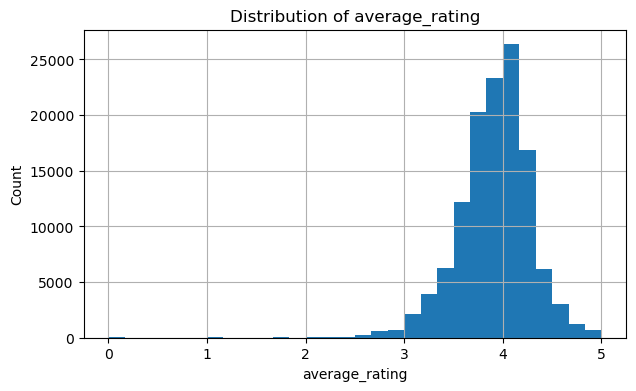

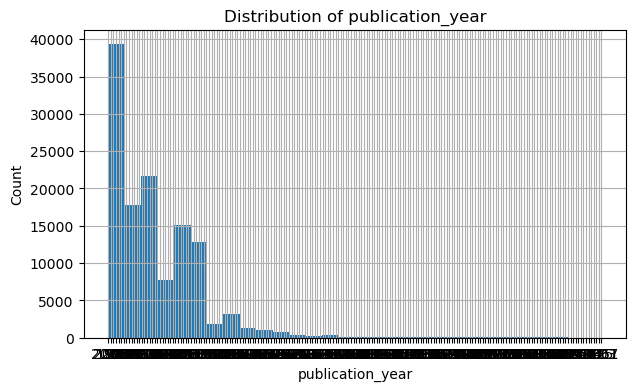

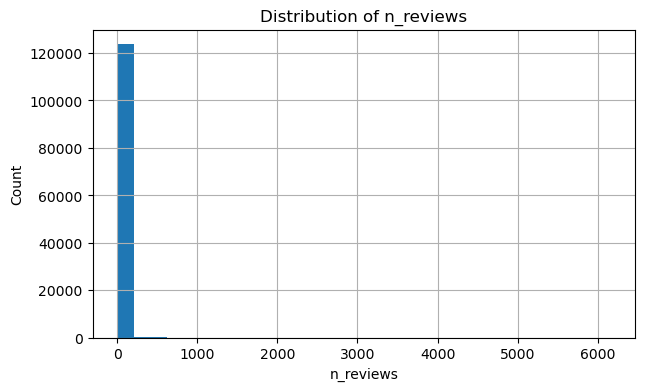

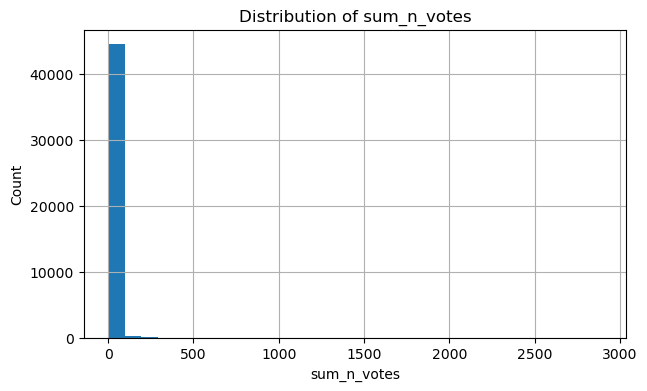

In [78]:
# Check for missing values
missing_summary = books_with_reviews.isnull().sum()
print("Missing values per column:\n", missing_summary)

# Describe numeric columns
numeric_summary = books_with_reviews.describe()
print("\nSummary statistics for numeric columns:\n", numeric_summary)

# Visualize distributions of numeric columns
import matplotlib.pyplot as plt

numeric_cols = ['average_rating', 'publication_year', 'n_reviews', 'sum_n_votes']
for col in numeric_cols:
    if col in books_with_reviews.columns:
        plt.figure(figsize=(7,4))
        books_with_reviews[col].hist(bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

In [80]:
# Save the final DataFrame as a CSV in data/clean
output_path = os.path.join(os.getcwd(), '..', 'data', 'clean', 'books_with_reviews.csv')
books_with_reviews.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /Users/karanmatnani/Documents/code/kids_book_recommender/src/../data/clean/books_with_reviews.csv
